## Model Building and Evaluation

In this notebook I will train a logistic regression and random forest classifier on the lead service line data. After a train/test split I will downsample the majority class (no lead) and use 5-fold cross validation to optimize the F1 statistic.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
from shapely.geometry import multipolygon
import shapely.wkt
import geopandas


# Begin Models

In [2]:
#Data too big to push to github.
lead_data = pd.read_csv('model_data.csv')
lead_data.shape

(604182, 21)

Create dummy variables of categorical data.

In [3]:
#lead_data = t
#Create dummy variables
dummy_cityowned = pd.get_dummies(lead_data['CityOwned'],prefix='city')
dummy_zip = pd.get_dummies(lead_data['zip'], prefix='zip')
dummy_taxclass = pd.get_dummies(lead_data['taxclass'],prefix='tax')

dummy_taxclass.drop('tax_1',inplace=True,axis=1)
dummy_cityowned.drop('city_No', inplace=True, axis=1)
dummy_zip.drop('zip_10002', inplace=True, axis=1)
all_dummy = pd.concat([dummy_taxclass,dummy_cityowned, dummy_zip], axis=1)
lead_data_dummies = pd.concat([lead_data, all_dummy], axis=1)


Here I will split the data into test and training set. I will then upsample the lead class in the training set. Note that the technique used below will be to oversample first, and then perform 5-fold cross validation. In the future I would look to oversample within each iteration of the cross validation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

lead_data_train, lead_data_test = train_test_split(lead_data_dummies, test_size=0.2)
dummy_names = list(all_dummy.columns)
tax_names = list(dummy_taxclass.columns)
zip_names = list(dummy_zip.columns)
city_names = list(dummy_cityowned.columns)
#features = ['Construction Year','fullval','bldfront','blddepth', 'GROUNDELEV','Lead_Index_tenth'] + tax_names + city_names
#features = ['Construction Year','Lead_Index_tenth','Lead_Index_quarter','bldfront','blddepth', 'GROUNDELEV'] +city_names + tax_names
features = ['Construction Year', 'Lead_Index_quarter','bldfront','blddepth','GROUNDELEV', 'Median_Income','nn_diff'] + city_names+tax_names

#Separate classes
lead = lead_data_train[lead_data_train['Pipe Material'] == 1]
no_lead = lead_data_train[lead_data_train['Pipe Material'] == 0]

#Upsample lead
lead_upsample = resample(lead, replace=True, n_samples=no_lead.shape[0]) 
 
#Combine the upsampled lead with no lead data
lead_upsample = pd.concat([no_lead, lead_upsample])
 

X_train = lead_upsample[features]
Y_train = lead_upsample['Pipe Material']
X_test = lead_data_test[features]
Y_test = lead_data_test['Pipe Material']


Here I begin the model building with a logistic regression. 

In [8]:
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



logreg = LogisticRegression()
#logreg.fit(X_train,Y_train)
scores = cross_validate(logreg, X_train, Y_train, cv=5, scoring = ('precision','recall','f1','roc_auc'))
print(scores)


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'fit_time': array([10.12019753, 10.6608851 ,  8.65703726,  9.08579254, 10.93073392]), 'score_time': array([1.32423925, 0.45177078, 0.411762  , 0.41076088, 0.39377189]), 'test_precision': array([0.64319584, 0.66638092, 0.6285698 , 0.64099266, 0.66626416]), 'train_precision': array([0.64418238, 0.66751582, 0.627793  , 0.63963112, 0.66727902]), 'test_recall': array([0.74585274, 0.73661382, 0.73525251, 0.74494181, 0.73638693]), 'train_recall': array([0.74489176, 0.73789258, 0.73468285, 0.74470577, 0.73806275]), 'test_f1': array([0.69073089, 0.69973947, 0.67773862, 0.68906899, 0.69957272]), 'train_f1': array([0.6908863 , 0.70094212, 0.67704503, 0.68818073, 0.70088828]), 'test_roc_auc': array([0.72561262, 0.75493651, 0.69448975, 0.71755764, 0.75465593]), 'train_roc_auc': array([0.72501676, 0.75610576, 0.69286445, 0.71706939, 0.75577704])}


Now we will evaluate the logistic regression on the test set.

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

#Fit the logistic regression
logreg.fit(X_train,Y_train)

#Predict
y_pred_log = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))


cm = confusion_matrix(Y_test, y_pred_log)
print(cm)
print(classification_report(Y_test,y_pred_log))





Accuracy of logistic regression classifier on test set: 0.66
[[59689 34269]
 [ 7091 19788]]
             precision    recall  f1-score   support

          0       0.89      0.64      0.74     93958
          1       0.37      0.74      0.49     26879

avg / total       0.78      0.66      0.69    120837



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.756


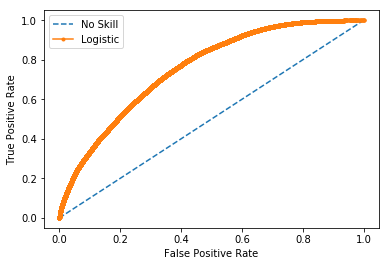

In [20]:
#no skill prob
ns_probs = [0 for _ in range(len(Y_test))]

#
lr_probs = logreg.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

I will now train random forest classifier. First I will see the validation scores using a 5-fold split. Then I will tune hyperparameters to optimize F1.

In [21]:
##### CROSS VAL RF
from sklearn.model_selection import KFold


rf=RandomForestClassifier(n_estimators =35)
scores = cross_validate(rf, X_train, Y_train, cv=5, scoring = ('precision','recall','f1','roc_auc'))
print(scores)


{'fit_time': array([112.30859041, 130.99887586, 121.58927107, 109.6031425 ,
       103.40569687]), 'score_time': array([23.76037431, 15.84091711, 15.50710773, 14.71955872, 14.79851341]), 'test_precision': array([0.87914715, 0.87999422, 0.87817643, 0.88000626, 0.87702029]), 'train_precision': array([0.99949972, 0.9995264 , 0.99950973, 0.99949973, 0.99942974]), 'test_recall': array([0.97677802, 0.97562994, 0.97640401, 0.97623051, 0.97623051]), 'train_recall': array([0.99990324, 0.9999266 , 0.99991992, 0.99991659, 0.9999266 ]), 'test_f1': array([0.92539465, 0.92534763, 0.92468892, 0.92562433, 0.92396989]), 'train_f1': array([0.99970144, 0.99972646, 0.99971479, 0.99970811, 0.99967811]), 'test_roc_auc': array([0.98511356, 0.98535695, 0.9851205 , 0.98514969, 0.98518944]), 'train_roc_auc': array([0.99999887, 0.99999883, 0.99999892, 0.99999888, 0.99999893])}


Next I will use 5-fold cross validation to tune hyperparameters to optimize F1. 

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
weight = ['balanced']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': weight}
print(random_grid)

{'n_estimators': [100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced']}


In [ ]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, scoring = 'f1', param_distributions = random_grid, n_iter = 20, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# Fit the random  search model
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [18]:
  rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': 'balanced',
 'bootstrap': True}

In [ ]:
rf_best = rf_random.best_estimator_

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Train best model
rf_best=RandomForestClassifier(n_estimators =150, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=None, class_weight='balanced', bootstrap=True)
rf_best.fit(X_train,Y_train)

y_pred_best = rf_best.predict(X_test)

print('Accuracy of best RF classifier on test set: {:.2f}'.format(rf_best.score(X_test, Y_test)))


cm_best = confusion_matrix(Y_test, y_pred_best)
print(cm_best)
print(classification_report(Y_test,y_pred_best))


Accuracy of best RF classifier on test set: 0.82
[[84469  9029]
 [12251 15088]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.89     93498
          1       0.63      0.55      0.59     27339

avg / total       0.82      0.82      0.82    120837



Accuracy of base RF classifier on test set: 0.81
[[87121  6377]
 [16070 11269]]
             precision    recall  f1-score   support

          0       0.84      0.93      0.89     93498
          1       0.64      0.41      0.50     27339

avg / total       0.80      0.81      0.80    120837

No Skill: ROC AUC=0.500
Random Forest (Base Model): ROC AUC=0.841
Random Forest (Best Model): ROC AUC=0.873


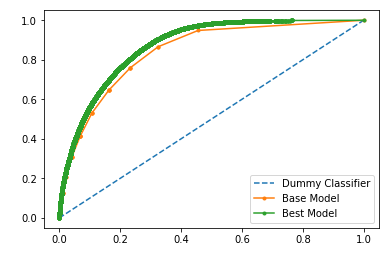

<Figure size 1080x1080 with 0 Axes>

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


rf_base=RandomForestClassifier(n_estimators =10, class_weight='balanced')

rf_base.fit(X_train,Y_train)
y_pred_base = rf_base.predict(X_test)

print('Accuracy of base RF classifier on test set: {:.2f}'.format(rf_base.score(X_test, Y_test)))


cm_base = confusion_matrix(Y_test, y_pred_base)
print(cm_base)
print(classification_report(Y_test,y_pred_base))


#no skill prob
ns_probs = [0 for _ in range(len(X_test))]
rf_base_probs = rf_base.predict_proba(X_test)
rf_best_probs = rf_best.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_base_probs = rf_base_probs[:, 1]
rf_best_probs = rf_best_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
rf_base_auc = roc_auc_score(Y_test, rf_base_probs)
rf_best_auc = roc_auc_score(Y_test, rf_best_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest (Base Model): ROC AUC=%.3f' % (rf_base_auc))
print('Random Forest (Best Model): ROC AUC=%.3f' % (rf_best_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
rf_base_fpr, rf_base_tpr, _ = roc_curve(Y_test, rf_base_probs)
rf_best_fpr, rf_best_tpr, _ = roc_curve(Y_test, rf_best_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifier')
pyplot.plot(rf_base_fpr, rf_base_tpr, marker='.', label='Base Model')
pyplot.plot(rf_best_fpr, rf_best_tpr, marker='.', label='Best Model')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.figure(figsize =(15,15))
# show the plot
pyplot.show()


# Naive Bayes

Accuracy of Gaussian NB classifier on test set: 0.56
[[42536 51422]
 [ 1827 25052]]
             precision    recall  f1-score   support

          0       0.96      0.45      0.62     93958
          1       0.33      0.93      0.48     26879

avg / total       0.82      0.56      0.59    120837

Accuracy: 0.55933199268436
No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.757


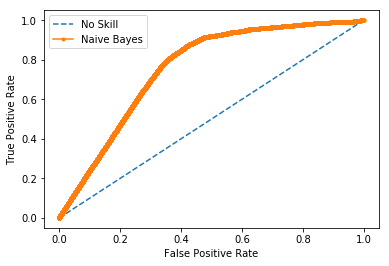

In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,Y_train)
predictions_gnb = gnb.predict(X_test)

print('Accuracy of Gaussian NB classifier on test set: {:.2f}'.format(gnb.score(X_test, Y_test)))

confusion_matgnb = confusion_matrix(Y_test,predictions_gnb.tolist())
print(confusion_matgnb)

print(classification_report(Y_test,predictions_gnb))
print('Accuracy:', accuracy_score(Y_test,predictions_gnb))

ns_probs = [0 for _ in range(len(Y_test))]
nb_probs = gnb.predict_proba(X_test)
# keep probabilities for the positive outcome only
nb_probs = nb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
nb_auc = roc_auc_score(Y_test, nb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(Y_test, nb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()